In [3]:
import time
import gymnasium as gym

from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

env = gym.make('LunarLander-v3')

In [7]:


class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)  # Correct input size
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def __len__(self):
        return len(self.buffer)
    
    def sample(self, num_samples):
        batch = random.sample(self.buffer, num_samples)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        return states, actions, rewards, next_states, dones

# Hyperparameters
epsilon = 1.0
batch_size = 128
discount = 0.99
learning_rate = 0.0001
cur_frame = 0
num_actions = env.action_space.n

device = "cpu"
print(device)

buffer = ReplayBuffer(100000)
state_dim = env.observation_space.shape[0]  # Get state size
main_nn = DQN(state_dim, num_actions).to(device)
target_nn = DQN(state_dim, num_actions).to(device)
target_nn.load_state_dict(main_nn.state_dict())
target_nn.eval()

optimizer = optim.Adam(main_nn.parameters(), lr=learning_rate)

# Epsilon-Greedy Action Selection
def select_epsilon_greedy_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return main_nn(state).argmax(dim=1).item()

# Training Step
def train_step(states, actions, rewards, next_states, dones):
    states, actions, rewards, next_states, dones = (
        states.to(device), actions.to(device), rewards.to(device), 
        next_states.to(device), dones.to(device)
    )
    
    next_qs = target_nn(next_states).max(1)[0]
    target = rewards + (1 - dones) * discount * next_qs
    
    qs = main_nn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
    loss = F.mse_loss(qs, target.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Training Loop
num_episodes = 1
trace = 50
max_steps = 500  # 10 seconds * 50 FPS
best=-np.inf
episode_reward_history=[]

start = time.time()
for episode in range(num_episodes):
    state, _ = env.reset()
    ep_reward, done, truncated = 0, False, False
    step_count = 0  # Track steps

    while not done and not truncated:
        state_in = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = select_epsilon_greedy_action(state_in, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        ep_reward += reward
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
        step_count += 1  # Increment step counter

        # Enforce truncation after 500 steps
        if step_count >= max_steps:
            truncated = True  # Mark as truncated to exit loop

        # Copy weights from main_nn to target_nn periodically
        if cur_frame % 2000 == 0:
            target_nn.load_state_dict(main_nn.state_dict())

        # Train the network
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones)
    episode_reward_history.append(ep_reward)
    if episode < num_episodes*0.95:
        epsilon -= 0.001/(num_episodes/1000)

    if episode % trace == 0:
        print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}. Reward: {ep_reward:.3f}')
    if ep_reward > best:
        best = ep_reward
        torch.save(main_nn, f'results_p1/lunar_lander_DQN_{num_episodes}.pt')
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo entreno: {int(minutos)} minutos y {segundos:.2f} segundos*******")

env.close()

cpu
Episode 0/1. Epsilon: 0.000. Reward: -167.124
*******Tiempo entreno: 0 minutos y 0.02 segundos*******


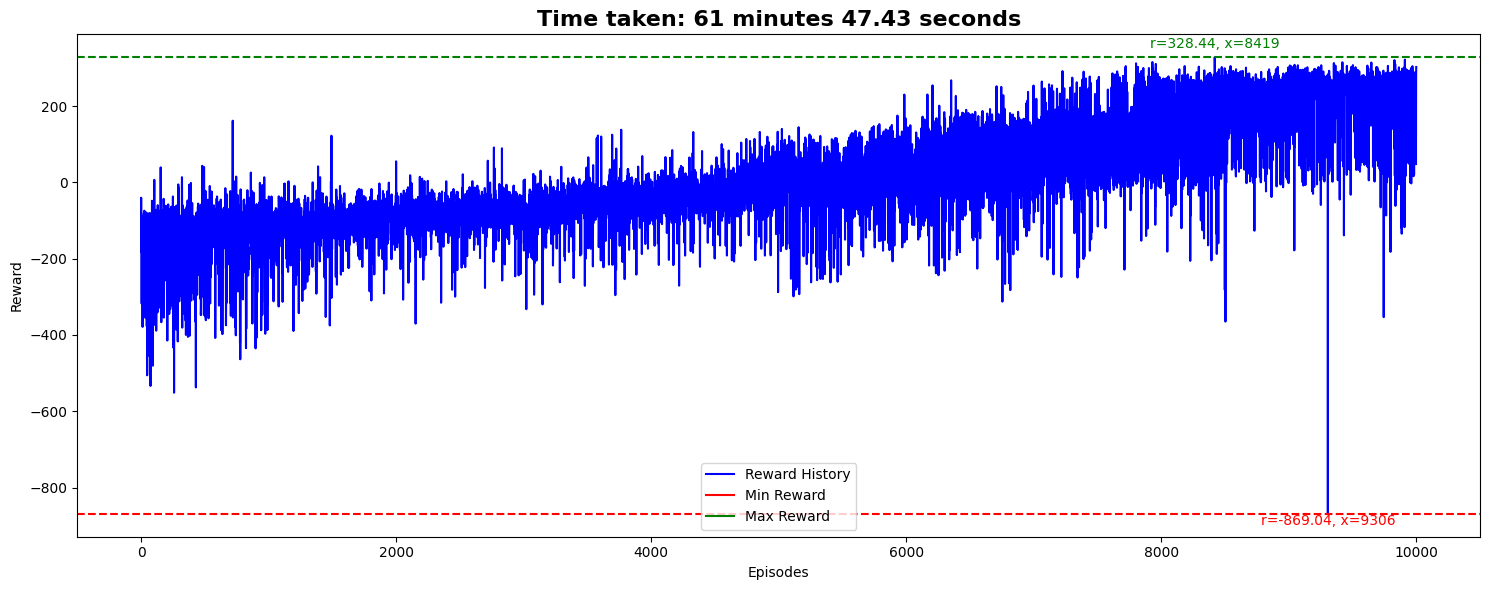

In [3]:
def plot_evolution():
    plt.figure(figsize=(15, 6))
    plt.plot(range(num_episodes), episode_reward_history, label="Reward History", color="blue")

    # Adding min and max bars
    min_reward = min(episode_reward_history)
    max_reward = max(episode_reward_history)
    min_episode = episode_reward_history.index(min_reward)
    max_episode = episode_reward_history.index(max_reward)

    ax = plt.gca()
    ymin_axis, ymax_axis = ax.get_ylim()
    offset = (ymax_axis - ymin_axis) * 0.02

    # Adjust offsets; change sign as needed (positive: above, negative: below)
    min_offset = -offset-1.9  # places min text below the line
    max_offset = offset-2.0   # places max text above the line

    plt.plot(min_reward, label="Min Reward", color='r')
    plt.axhline(y=min_reward, color='red', linestyle='--')
    plt.text(min_episode, min_reward + min_offset, f"r={min_reward:.2f}, x={min_episode}", color='r', ha="center")

    plt.plot(max_reward, label="Max Reward", color='g')
    plt.axhline(y=max_reward, color='green', linestyle='--')
    plt.text(max_episode, max_reward + max_offset, f"r={max_reward:.2f}, x={max_episode}", color='g', ha="center")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title(f"Time taken: {int(minutos)} minutes {segundos:.2f} seconds", fontsize=16, ha='center', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results_p1/lunar_lander_DQN_{num_episodes}.png")
    plt.show()

plot_evolution()

In [9]:

test_model = torch.load(f'results_p1/lunar_lander_DQN_{num_episodes}.pt',weights_only=False)

num_episodes_test = 10
destiny_folder = "results_p1/videos"
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix=f"LL-DQN-{num_episodes}", episode_trigger=lambda x: x < num_episodes_test)  

def policy(state):
    state_tensor = torch.tensor(state, dtype=torch.float)
    with torch.no_grad():  # Disable gradient calculation
        action_values = test_model(state_tensor)
    return torch.argmax(action_values).item()
    
for episode in range(num_episodes_test):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state
        if done:
            print(f"Episode {episode}: Total Reward = {total_reward}")

test_env.close()

/home/jaime/Escritorio/UPM/rl/RLGAN-project-MAADM-UPM/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/jaime/Escritorio/UPM/rl/RLGAN-project-MAADM-UPM/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jaime/Escritorio/UPM/rl/RLGAN-project-MAADM-UPM/results_p1/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 0: Total Reward = 256.11504952397405
Episode 1: Total Reward = 253.51161787759293
Episode 2: Total Reward = 267.52438645827885
Episode 3: Total Reward = 284.94111619220394
Episode 4: Total Reward = 288.0354651116275
Episode 5: Total Reward = 246.45282625589957
Episode 6: Total Reward = 263.2124374534012
Episode 7: Total Reward = 267.3024273606909


KeyboardInterrupt: 